In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Incumbency has no relationship with their stance on the 2020 election

1: normal TVD A/B test to see if the distributions are different 

2: A/B test for proportion of no comment 

3: A/B test for proportion of full deniers 

If they won the primary has no relationship with their stance on the 2020 election

4: normal TVD A/B test to see if distributions of stances are different from winners/losers

5: A/B test for proportion of no comment

6: A/B test for proportion of full deniers

In [2]:
dems = pd.read_csv('data/fivethirtyeight/dem_candidates.csv')
reps = pd.read_csv('data/fivethirtyeight/rep_candidates.csv', encoding = 'ISO-8859-1')
reps

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,2020 Election Stance,Trump,Trump Date,Club for Growth,Party Committee,Renew America,E-PAC,VIEW PAC,Maggie's List,Winning for Women
0,"Aditya ""A.D."" Atholi",Male,Asian (Indian),NaN,NaN,No,No,Texas,3/1/22,Representative,...,No comment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Joe McDaniel,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,Raised questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nathaniel Moran,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,Raised questions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,John Porro,Male,White,NaN,NaN,No,No,Texas,3/1/22,Representative,...,No comment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Dan Crenshaw,Male,White,NaN,NaN,Yes,No,Texas,3/1/22,Representative,...,Accepted with reservations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,Karen Testerman,Female,Asian (Japanese),White,NaN,No,Yes,New Hampshire,9/13/22,Governor,...,Fully denied,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1595,Allen R. Waters,Male,Black,NaN,NaN,No,No,Rhode Island,9/13/22,Representative,...,No comment,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN
1596,Allan W. Fung,Male,Asian (Chinese),NaN,NaN,No,No,Rhode Island,9/13/22,Representative,...,Accepted with reservations,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN
1597,Ashley Marie Kalus,Female,White,NaN,NaN,No,No,Rhode Island,9/13/22,Governor,...,Avoided answering,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
reps['Runoff Outcome'] = reps['Runoff Outcome'].map({'Lost': 0, 'Won': 1, np.NaN: 0})
reps['Final Outcome'] = reps['Primary Outcome'].map({'Lost': 0, 'Made runoff': 0, 'Won': 1})
reps['Final Outcome'] = np.array(reps['Final Outcome']) + np.array(reps['Runoff Outcome'])

In [4]:
reps_outcome = reps.groupby(['2020 Election Stance', 'Final Outcome']).count()
reps_outcome = reps_outcome.reset_index()[['2020 Election Stance', 'Final Outcome', 'Candidate']].rename(columns = {'Candidate': 'Count', 'Final Outcome': 'Won?'})

In [8]:
reps_small = reps[['2020 Election Stance', 'Final Outcome', 'Incumbent']]

reps_big = pd.get_dummies(reps_small, columns=['2020 Election Stance'])
reps_big['2020 Election Stance_Avoided or No comment'] = reps_big['2020 Election Stance_Avoided answering'] + reps_big['2020 Election Stance_No comment']
reps_filt = reps_big[['2020 Election Stance_Avoided or No comment', '2020 Election Stance_Fully denied', '2020 Election Stance_No comment', '2020 Election Stance_Fully accepted', 'Final Outcome', 'Incumbent']]
reps_filt.groupby('Incumbent').count()

reps_shuffled = reps_filt.sample(frac=1, replace=False)
reps_shuffled.groupby('Incumbent').count()

# final outcome is 0 first, 1 second

# incumbent is no first, yes second

,2020 Election Stance_Avoided or No comment,2020 Election Stance_Fully denied,2020 Election Stance_No comment,2020 Election Stance_Fully accepted,Final Outcome
Incumbent,,,,,
No,1383,1383,1383,1383,1383
Yes,216,216,216,216,216


In [31]:
def proportion_ab_test(reps_filt, ab_col, vals_col, direction):
    if direction == 'a>b':
        def obs_stat(reps_filt, ab_col=ab_col):
            return reps_filt.groupby(ab_col).mean()[vals_col][0] - reps_filt.groupby(ab_col).mean()[vals_col][1]
    elif direction == 'a<b':
        def obs_stat(reps_filt, ab_col=ab_col):
            return reps_filt.groupby(ab_col).mean()[vals_col][1] - reps_filt.groupby(ab_col).mean()[vals_col][0]
    else:
        def obs_stat(reps_filt, ab_col=ab_col):
            return np.abs(reps_filt.groupby(ab_col).mean()[vals_col][0] - reps_filt.groupby(ab_col).mean()[vals_col][1])
        
    obs_diff = obs_stat(reps_filt)
    
    diffs = np.zeros(1000)
    for i in np.arange(1000):
        reps_filt['shuffled'] = reps_filt[ab_col].sample(frac=1, replace=False).values
        diffs[i] = obs_stat(reps_filt, 'shuffled')
    
    pval = np.mean(diffs >= obs_diff)
    
    return {'diffs': diffs, 'obs': obs_diff, 'pval': pval}

p-val: 0.0174


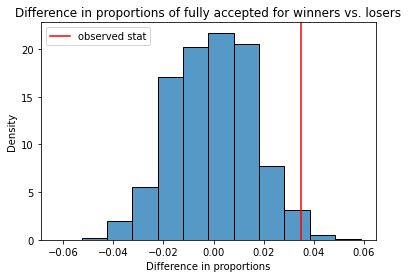

In [24]:
result = proportion_ab_test('Final Outcome', '2020 Election Stance_Fully accepted', 'a<b')

sns.histplot(result['diffs'], bins=12, stat='density')
plt.title('Difference in proportions of fully accepted for winners vs. losers')
plt.xlabel('Difference in proportions')
plt.axvline(result['obs'], color='red', label = 'observed stat')
plt.legend();
print('p-val:', result['pval'])

Incumbency has no relationship with their stance on the 2020 election

1: normal TVD A/B test to see if the distributions are different 

2: A/B test for proportion of no comment 

3: A/B test for proportion of full deniers 

If they won the primary has no relationship with their stance on the 2020 election

4: normal TVD A/B test to see if distributions of stances are different from winners/losers

5: A/B test for proportion of no comment

6: A/B test for proportion of full deniers

In [25]:
reps.groupby('Final Outcome').count()

,Candidate,Gender,Race 1,Race 2,Race 3,Incumbent,Incumbent Challenger,State,Primary Date,Office,...,2020 Election Stance,Trump,Trump Date,Club for Growth,Party Committee,Renew America,E-PAC,VIEW PAC,Maggie's List,Winning for Women
Final Outcome,,,,,,,,,,,,,,,,,,,,,
0,1114,1114,1114,21,1,1114,1114,1114,1114,1114,...,1114,411,14,97,131,30,88,212,146,64
1,485,485,485,9,0,485,485,485,485,485,...,485,186,178,23,53,16,18,57,49,24


# power calculation

In [ ]:
from scipy.stats import bernoulli
from scipy.stats import uniform

pvals = np.zeros(1000)
fake_p = uniform.rvs(size=1000)

for i in np.arange(1000):
    fake_winners = pd.DataFrame({'Final Outcome': 1, 'Fully accepted': bernoulli.rvs(p=max(fake_p[i]+0.015, 1), size=485)})
    fake_losers = pd.DataFrame({'Final Outcome': 0, 'Fully accepted': bernoulli.rvs(p=min(fake_p[i]-0.015, 0), size=1114)})
    fake_data = pd.concat([fake_winners, fake_losers])
    pvals[i] = proportion_ab_test(fake_data, 'Final Outcome', 'Fully accepted', 'a<b')['pval']

In [35]:
pvals

array([0.312, 0.314, 0.202, 0.921, 0.645, 0.704, 0.453, 0.14 , 0.82 ,
       0.093])

# hypothesis test

In [29]:
from scipy.stats import bernoulli
from scipy.stats import uniform

pvals = np.zeros(1000)
fake_p = uniform.rvs(size=1000)


fake_winners = pd.DataFrame({'Final Outcome': 1, 'Fully accepted': bernoulli.rvs(p=fake_p[0]+0.01, size=485)})
fake_losers = pd.DataFrame({'Final Outcome': 0, 'Fully accepted': bernoulli.rvs(p=fake_p[0]+0.01, size=1114)})

,Final Outcome,Fully accepted
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
...,...,...
1109,0,1
1110,0,1
1111,0,1
1112,0,1
